# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which was the most convenient neural network environment when the work involves defining new layers some time ago. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
from layers.module import Module
from layers.linear import Linear
from layers.batch_mean_subtraction import BatchMeanSubtraction
from layers.dropout import Dropout
from layers.relu import ReLU
from layers.leakyrelu import LeakyReLU
from layers.elu import ELU
from layers.softplus import SoftPlus
from layers.softmax import SoftMax

from layers.criterion import Criterion
from layers.class_nll import ClassNLLCriterion
from layers.mse import MSECriterion

from layers.sequential import Sequential

%load_ext autoreload
%autoreload 2

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            state['old_grad'][i] = cur_old_grad 
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

In [4]:
def adam(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - beta1
            - beta2
            - learning_rate
        state:
            - old_grad
            - first_moment
            - second_moment
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    state.setdefault('first_moment', {})
    state.setdefault('second_moment', {})
    state.setdefault('j', 1)
    beta1 = config['beta1']
    beta2 = config['beta2']
    j = state['j']
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            first_moment = beta1 * state['first_moment'].setdefault(i, np.zeros_like(cur_dx)) + \
                            (1 - beta1) * cur_dx
            first_moment = first_moment / (1 - beta1 ** j)
            second_moment = beta2 * state['second_moment'].setdefault(i, np.zeros_like(cur_dx)) + \
                            (1 - beta2) * cur_dx * cur_dx
            second_moment = second_moment / (1 - beta2 ** j)
            curr_step = config['learning_rate'] * first_moment / (np.sqrt(second_moment) + 1e-7)
            state['first_moment'][i] = first_moment
            state['second_moment'][i] = second_moment
            
            if curr_step.shape[0] == 1:
                cur_x = cur_x.reshape(curr_step.shape)
            
            np.add(cur_x, -curr_step, out=cur_x)
            i += 1     
    state['j'] += 1

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

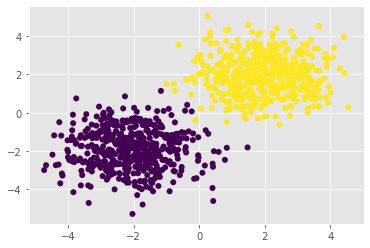

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N), np.zeros(N)])[:,None]
Y = np.hstack([Y, 1 - Y])

X = np.vstack([X1, X2])
plt.scatter(X[:,0], X[:,1], c=Y[:,0], edgecolors='none')

Define a **logistic regression** for debugging. 

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [7]:
def train(net, criterion, X, Y, n_epoch=20, opt='sgd_momentum'):
    loss_history = []
    first = True
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches(X, Y, batch_size):

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            eval(opt)(net.getParameters(), 
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title('Training loss')
        plt.xlabel('#iteration')
        plt.ylabel('loss')
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
    return loss_history

In [8]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 8))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Dropout())
net.add(Linear(8, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 8
BatchMeanNormalization
ReLU
Dropout
Linear 8 -> 2
SoftMax



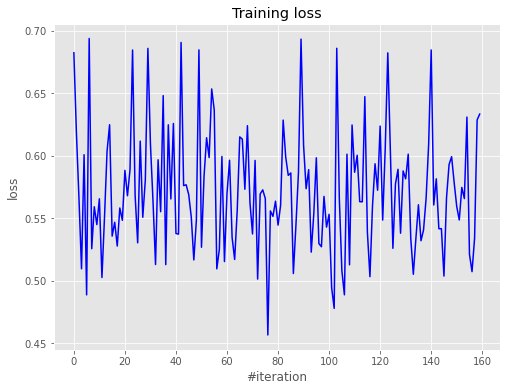

Current loss: 0.633286
Accuracy:  0.985


In [9]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'beta1': 0.9, 'beta2': 0.999}
optimizer_state = {}
# Looping params
n_epoch = 20
batch_size = 128
net.zeroGradParameters()
train(net, criterion, X, Y, n_epoch, 'adam')
net.evaluate()
pred = np.argmax(net.updateOutput(X), axis=-1)
print('Accuracy: ', accuracy_score(np.argmax(Y, axis=-1), pred))

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [10]:
digits = load_digits()
X, y = digits['data'] / 16.0, digits['target']

One-hot encode the labels first.

In [11]:
enc = OneHotEncoder()
one_hot_y = enc.fit_transform(y.reshape(-1, 1)).todense()

In [12]:
one_hot_y = np.squeeze(np.asarray(one_hot_y))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [13]:
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 10
SoftMax



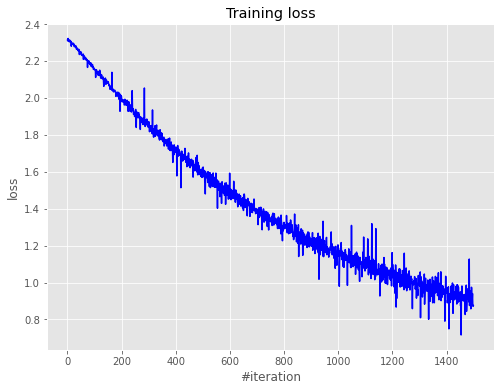

Current loss: 0.875455
0.890929326655537


In [14]:
single_layer_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

In [15]:
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 32))
net.add(ReLU())
net.add(Linear(32, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 32
ReLU
Linear 32 -> 10
SoftMax



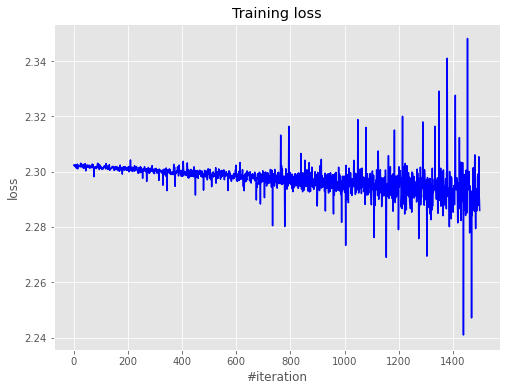

Current loss: 2.285958
0.19031719532554256


In [16]:
lr = 2 * 1e-4
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
no_batch_norm_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

In [17]:
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 32))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(32, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 32
BatchMeanNormalization
ReLU
Linear 32 -> 10
SoftMax



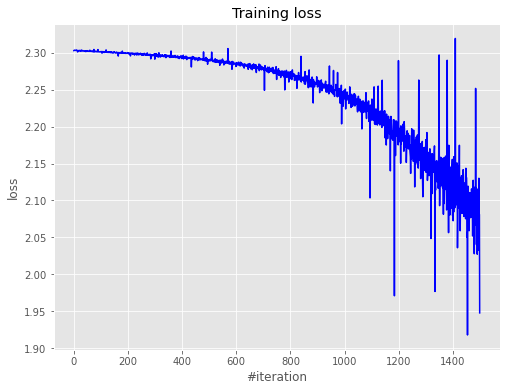

Current loss: 1.947722
0.3656093489148581


In [18]:
lr = 1e-3
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
relu_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

In [19]:
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 64))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Dropout())
net.add(Linear(64, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 64
BatchMeanNormalization
ReLU
Dropout
Linear 64 -> 10
SoftMax



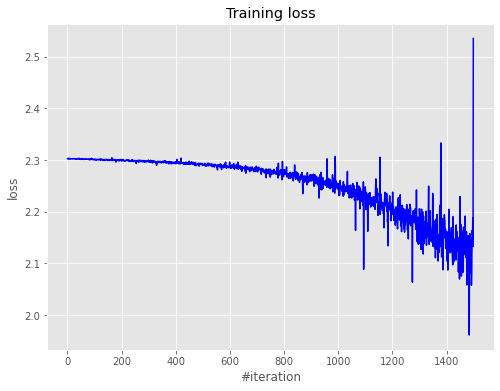

Current loss: 2.534880
0.32276015581524764


In [20]:
lr = 1e-3
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
dropout_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

In [21]:
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 32))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(32, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 32
BatchMeanNormalization
LeakyReLU
Linear 32 -> 10
SoftMax



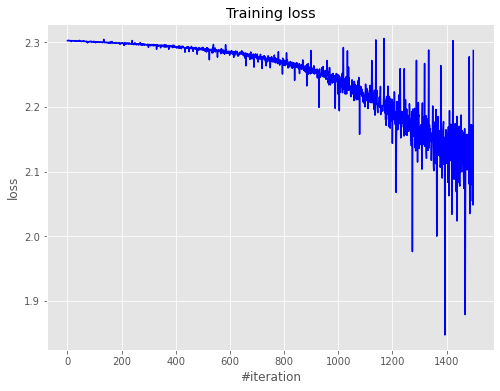

Current loss: 2.287244
0.3311074012242627


In [22]:
lr = 1e-3
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
leaky_relu_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

In [23]:
# Iptimizer params
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 32))
net.add(BatchMeanSubtraction())
net.add(ELU())
net.add(Linear(32, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 32
BatchMeanNormalization
ELU
Linear 32 -> 10
SoftMax



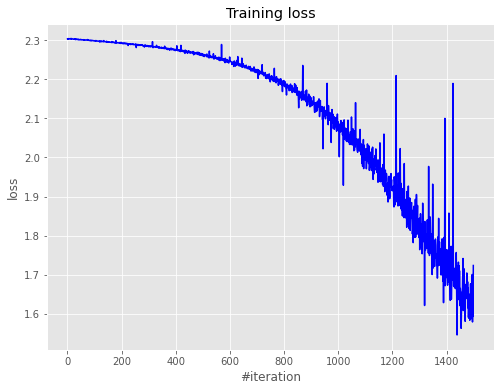

Current loss: 1.723551
0.533667223149694


In [24]:
lr = 1e-3
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
elu_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

In [25]:
# Iptimizer params
optimizer_state = {}
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 32))
net.add(BatchMeanSubtraction())
net.add(SoftPlus())
net.add(Linear(32, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 32
BatchMeanNormalization
SoftPlus
Linear 32 -> 10
SoftMax



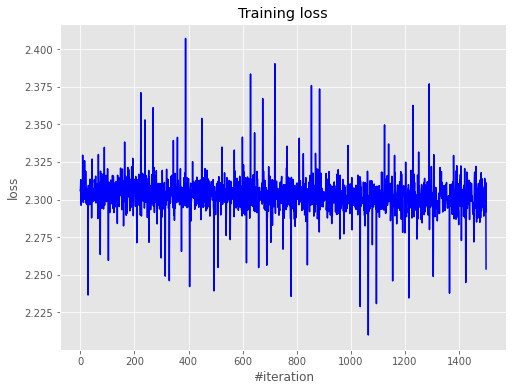

Current loss: 2.253835
0.1001669449081803


In [26]:
lr =  2 * 1e-4
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
softplus_history = train(net, criterion, X, one_hot_y, 100)
pred = np.argmax(net.updateOutput(X), axis=-1)
print(accuracy_score(y, pred))

In [27]:
def smooth(history, alpha=0.9):
    memory = history[0]

    smooth_history = []
    for elem in history:
        new_elem = alpha * memory + (1 - alpha) * elem
        smooth_history.append(new_elem)
        memory = new_elem
    return smooth_history

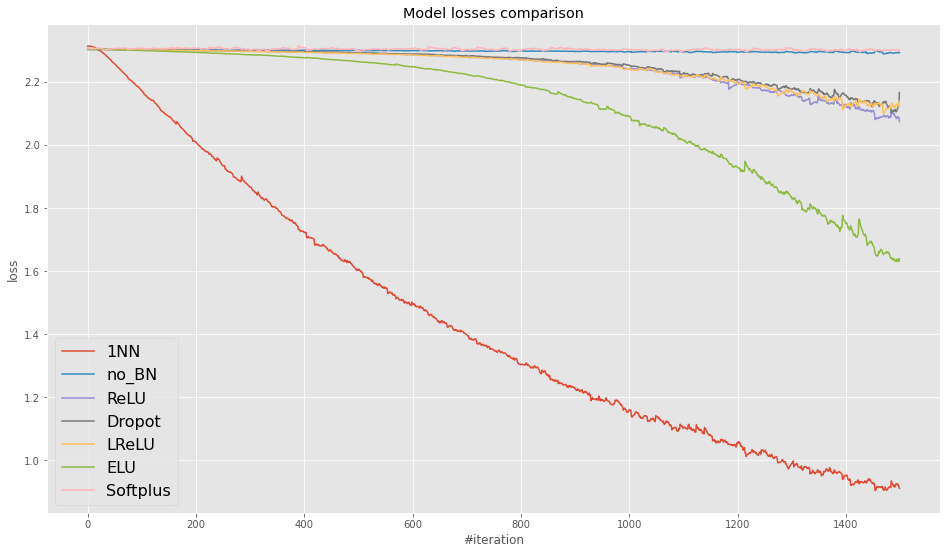

In [28]:
plt.figure(figsize=(16, 9))
plt.title('Model losses comparison')
plt.xlabel('#iteration')
plt.ylabel('loss')
plt.plot(smooth(single_layer_history), label='1NN')
plt.plot(smooth(no_batch_norm_history), label='no_BN')
plt.plot(smooth(relu_history), label='ReLU')
plt.plot(smooth(dropout_history), label='Dropot')
plt.plot(smooth(leaky_relu_history), label='LReLU')
plt.plot(smooth(elu_history), label='ELU')
plt.plot(smooth(softplus_history), label='Softplus')
plt.legend(prop={'size': 16})
plt.show()

Seems like logistic regression weroks the best. It also will be easier to train because it's cost functiion is convex.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [29]:
X_train, X_test, y_train, y_test =  train_test_split(
    X, one_hot_y, test_size=0.2, random_state=42)

Print here your accuracy. It should be around 90%.

In [47]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(64, 10))
net.add(SoftMax())

print(net)

Linear 64 -> 10
SoftMax



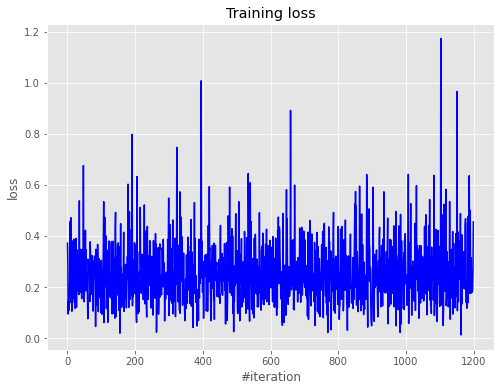

Current loss: 0.454827


In [48]:
optimizer_state = {}
history = []
train_acc = []
test_acc = []
for lr in [0.1, 0.05]:
    optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
    history.extend(train(net, criterion, X_train, y_train, 100))
    pred_train = np.argmax(net.updateOutput(X_train), axis=-1)
    train_acc.append(accuracy_score(np.argmax(y_train, axis=-1), pred_train))
    pred_test = np.argmax(net.updateOutput(X_test), axis=-1)
    test_acc.append(accuracy_score(np.argmax(y_test, axis=-1), pred_test))
    sleep(1)

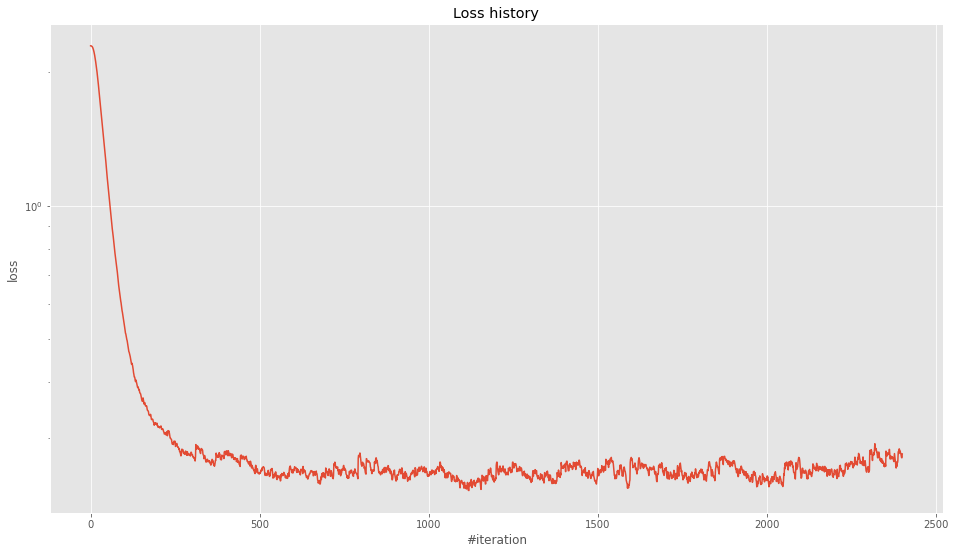

Train accuracy:  0.9359777313848295 0.9394572025052192
Test accuracy:   0.9305555555555556 0.9361111111111111


In [57]:
plt.figure(figsize=(16, 9))
plt.title('Loss history')
plt.xlabel('#iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.plot(smooth(history, 0.97))
plt.show()
print('Train accuracy: ', *train_acc)
print('Test accuracy:  ', *test_acc)

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](https://multithreaded.stitchfix.com/assets/images/blog/PS_NN_graphic_colors2.png)

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [33]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [34]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [35]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################